# Tutorial 5: Designing a "fab-ready" chip with `SQuADDS`

In this tutorial, we will go over how to use `SQuADDS` to design a fabrication ready chip addressing practical design constraints.

## Chip Design Idea

We aim to design a chip with the following specifications:

1. A qubit with a target frequency of 3.7 GHz and an anharmonicity of -210 MHz.
2. A readout resonator with a frequency determined by $ f_r = 2(f_q + \alpha) $
3. Strong coupling between the qubit and the cavity (i.e. punchout shift $\approx$ few MHz).
4. Microwave measurements will be done in transmission.
5. The design must allow for qubit drive functionality.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## Query the SQuADDS Database

Let's first query for the qubit-cavity pair of our interest.

In [3]:
import numpy as np

from squadds import Analyzer, SQuADDS_DB

In [4]:
# Make a connection to the SQuADDS database
db = SQuADDS_DB()
db.select_system(["cavity_claw", "qubit"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
df = db.create_system_df()


# Initialize the Analyzer
analyzer = Analyzer(db)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Query for the desired Hamiltonian parameters

In [5]:
target_params = {
                "qubit_frequency_GHz": 3.7,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -210,
                "g_MHz": 100 # should provide a big punchout shift
                }

# computing the cavity frequency desired as per the design requirements
target_params["cavity_frequency_GHz"] = 2*(target_params["qubit_frequency_GHz"]+target_params["anharmonicity_MHz"]/1000)

In [6]:
results = analyzer.find_closest(
    target_params=target_params,
    num_top=1,
    metric="Euclidean",
)
results

Time taken to add the coupled H params: 4.095033645629883 seconds


,index_qc,PI_qubit,date_created_qubit,group_qubit,institution_qubit,uploader_qubit,claw_to_claw,claw_to_ground,cross_to_claw,cross_to_cross,...,resonator_type,renderer_options_cavity_claw,setup_cavity_claw,simulator_cavity_claw,design_options,EC,EJ,qubit_frequency_GHz,anharmonicity_MHz,g_MHz
12514,1900,"Eli Levenson-Falk, PhD",2023-09-20-142549,LFL,USC,Andre Kuo,102.50358,94.66779,7.2447,100.07658,...,quarter,None,"{'basis_order': 1, 'max_delta_f': 0.05, 'max_p...",Ansys HFSS,{'cavity_claw_options': {'coupler_type': 'CLT'...,0.180488,10.278024,3.66213,-205.109839,98.903433


Lets extract all the relevant design parameters from `SQuADDS` for our target Hamiltonian parameters.

In [7]:
data_qubit = analyzer.get_qubit_options(results)
data_cpw = analyzer.get_cpw_options(results)
data_coupler = analyzer.get_coupler_options(results)
LJs = analyzer.get_Ljs(results) # in nH

**Fabrication sadly is not perfect and we need to account for that in the design** 

To ensure we have at least workable device and we will spray the resonators such that they land on $\omega_{02}$ within fab uncertainties. We are going to create 4 such devices.

In [9]:
num_pairs = 4

Let's assume that our fab facility has an uncertainy of $\pm$ 0.75 GHz (seems very high but not uncommon) for the qubit frequency because we cannot control $L_J$  very well.

In [10]:
fab_errors = 0.75 # GHz

The resonator frequency, on the other hand, is **much more stable** and easy to realize with high accuracy. Since, for this design we want the cavity to land on $\approx \omega_{02}$, we will need to adjust the resonator length to account for the uncertainty in the qubit frequency.

Let's compute the maximum and minimum resonator frequencies that we need with the given qubit frequency uncertainty.

In [11]:
w_cav = target_params["cavity_frequency_GHz"]

w_min = w_cav - 2*fab_errors
w_max = w_cav + 2*fab_errors
w_min, w_max

(5.48, 8.48)

We will now "spray" the resonator frequencies within this range.

In [12]:
target_cav_freqs = np.linspace(w_min,w_max,num_pairs) #GHz
target_cav_freqs

array([5.48, 6.48, 7.48, 8.48])

Let's now get the updated resonator CPW lengths corresponding to these frequencies

In [13]:
from squadds.core.utils import string_to_float

In [14]:
target_cpw_length = string_to_float(data_cpw["total_length"][0])

cpw_lengths = target_cpw_length * (target_params["cavity_frequency_GHz"]/ target_cav_freqs)
cpw_lengths

# add "um" to the cpw lengths
cpw_lengths = [f"{length}um" for length in cpw_lengths]

SQuADDS gave us the $L_j$ values needed for our qubit fabrication. However, we need to compute the junction geometries that would give us these $L_j$ values.

For that we would first decide on the junction type. Depending on your fab facility, you may have all the freedom to choose any junction type or you may be constrained to some specific junction types and sizes.

For the sake of this tutorial, let's say our hypothetical fab facility imposes the following constraints (very realistic):

0. They can only make Dolan Josephson junctions.
1. The junction length can only be 200 nm.
2. The junction width can only be a multiple of 10 nm but at minimum 100 nm.
3. The facility allows only 4 different current densities, $J_C \in 0.1, 0.25, 1.0, 3.0 \mu A/\mu m^2$.


We need to compute the junction sizes that would give us the desired $L_j$ values in adherence to these constraints.

**Recall:**

$L_J = \frac{\Phi_0}{2\pi I_c}$

$I_c = J_c \times A = J_c \times (l_{JJ} \times w_{JJ})$


Since we know what our $L_J$ target is and $l_{JJ}$ is fixed by the foundry. Let's calculate what $w_{JJ}$ needs to be for each $J_C$ they offer

In [15]:
def compute_JJ_width(Lj, current_density, JJ_length):
    """
    Compute the width of the Josephson Junction (JJ) for a Dolan style junction.
    
    Args:
    - Lj (float): Desired Josephson inductance in nH.
    - current_density (float): Current density in μA/μm².
    - JJ_length (float): Length of the Josephson Junction in nm.
    
    Returns:
    - float: Width of the Josephson Junction in nm.
    """
    # Convert units
    Lj = Lj * 1e-9  # nH to H
    current_density = current_density * 1e-6  # μA/μm² to A/μm²
    JJ_length = JJ_length * 1e-3  # nm to μm

    # Constants
    phi_0 = 2.067833848e-15  # Flux quantum in Wb

    # Calculate the critical current
    Ic = phi_0 / (2 * np.pi * Lj)

    # Calculate the JJ_width
    JJ_width = Ic / (current_density * JJ_length)

    return JJ_width * 1e3  # Convert from μm to nm

In [16]:
def round_to_multiple_of_10(n: float) -> float:
    """
    Rounds a float number to the nearest multiple of 10.

    Parameters:
    - n (float): The number to be rounded in nm

    Returns:
    - float: The rounded number in nm
    """

    # Identify the decimal component of the number
    integer_part, decimal_part = divmod(n, 1)

    # Find the nearest multiple of 10 for the integer part
    rounded_integer = round(integer_part / 10) * 10

    if decimal_part >= 0.5:
        rounded_integer += 10

    return rounded_integer

In [17]:
current_densities = [0.1, 0.25, 1, 3.0]  # in μA/μm²
foundry_min_JJ_width = 100  #nm

JJ_length = 200  #nm

# Compute JJ_width for each Lj and each current density
JJ_widths_for_Ljs = {}
for Lj in LJs:
    JJ_widths_for_Ljs[Lj] = {}
    for Jc in current_densities:
        JJ_widths_for_Ljs[Lj][Jc] = round_to_multiple_of_10(compute_JJ_width(Lj, Jc, JJ_length))

JJ_widths_for_Ljs

{15.903982052718824: {0.1: 1040, 0.25: 420, 1: 100, 3.0: 30}}

We should use $J_C = 0.25 \mu A/ \mu m^2$ for this run since that satisfies our fab constraints and gives us a reasonable $w_{JJ}$

In [18]:
J_C = 0.25 # μA/μm²
JJ_width = JJ_widths_for_Ljs[LJs[0]][J_C] # nm
JJ_width

420

## Making the Design

We will use `qiskit-metal` to create the design. 


Importing all the qiskit-metal and helper libraries 

In [19]:
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [20]:
from collections import OrderedDict

import numpy as np
import qiskit_metal as metal
from qiskit_metal import Dict
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

Using the custom `TransmonCross` component from `SQuADDS` to create the qubits.

In [21]:
from squadds.components.qubits import TransmonCross

Defining some helper methods to create the various structures we need in our design.

In [22]:

def create_qubit(name, pos_x, pos_y, orientation,JJ_flip,LJ,jj_width,jj_length,claw_gap, claw_length, claw_width, cross_length, cross_width, cross_gap, ground_spacing, **kwargs):
    xmon_options = dict(
        connection_pads=dict(
            c=dict(connector_location='90', connector_type='0',
                   claw_length=claw_length,
                   claw_gap=claw_gap,
                   ground_spacing=ground_spacing,
                   claw_width=claw_width,
                   claw_cpw_length='0um'),
        ),
        cross_length=cross_length,
        cross_gap=cross_gap,
        orientation=orientation,
        pos_x=pos_x,
        pos_y=pos_y,
        cross_width=cross_width,
        hfss_inductance=LJ * 10**(-9),
        aedt_hfss_inductance=LJ * 10**(-9),
        style="JJ_Dolan",
        Dolan_JJ  = Dict(JJ_width = f'{jj_width}nm',
                          JJ_flip  = JJ_flip),
        **kwargs
    )
    return TransmonCross(design, name, options=xmon_options)

def create_cpw(name, start_component, end_component, total_length, trace_gap, trace_width):
    cpw_opts = Dict(
        pin_inputs=Dict(start_pin=Dict(component=start_component, pin='second_end'),
                        end_pin=Dict(component=end_component, pin='c')),
        lead=Dict(start_straight='5um', end_straight='0um'),
        fillet='30.9um',
        total_length=total_length,
        trace_width=trace_width,
        meander=Dict(spacing='100um', asymmetry='-50um'),
        trace_gap=trace_gap
    )
    return RouteMeander(design, name, options=cpw_opts)

def create_clt(name, orientation, pos_y, coupling_length, coupling_space, down_length, prime_gap, prime_width, second_gap, second_width):
    clt_opts = Dict(
        prime_width=prime_width,
        prime_gap=prime_gap,
        second_width=second_width,
        second_gap=second_gap,
        coupling_space=coupling_space,
        coupling_length=coupling_length,
        open_termination=False,
        orientation=orientation,
        pos_y=pos_y,
        down_length=down_length
    )
    return CoupledLineTee(design, name, options=clt_opts)

def create_wirebond(name, orientation, pos_y, pad_width='160um', pad_length='200um', tapper_height='200um', trace_width="11.7um",trace_gap="5.1um"):
    options = Dict(
        orientation=orientation,
        pos_y=f"{pos_y}mm",
        pad_width=pad_width,
        pad_length=pad_length,
        tapper_height=tapper_height,
        trace_width=trace_width,
        trace_gap=trace_gap
    )
    return LaunchpadWirebond(design, name, options=options)


def create_feedline(name, start_component, start_pin, end_component, end_pin, trace_width='11.7um', trace_gap='5.1um'):
    options = Dict(
        pin_inputs=Dict(
            start_pin=Dict(component=start_component, pin=start_pin),
            end_pin=Dict(component=end_component, pin=end_pin)
        ),
        trace_width=trace_width,
        trace_gap=trace_gap
    )
    return RouteStraight(design, name, options=options)

Before designing the chip, we need to think about our requirements, resources and constraints.



Let's start with our board - since we are planning to have 4 qubits each with its own drive line and measure in transmission (2 ports), we need to ensure that we have have a total of 6 ports.





<div style="text-align: center;">
  <div style="display: inline-flex; justify-content: center; align-items: center; gap: 20px;">
    <div style="flex: 1; text-align: center;">
      <img src="board.png" alt="Figure 1" style="width: 20%;">
    </div>
  </div>
</div>


The board cut out is about 5.4mm x 5.4mm so we need to ensure our chip size is less than that and give ourselves enough room for chip packaging and removal safely (and without much stress) with a tweezer.

Let's start the GUI instance and create the design for a chip that is 5 mm x 5 mm

In [23]:
design = metal.designs.design_planar.DesignPlanar()
design.overwrite_enabled = True
design._chips.main.size.size_x = '5mm'
design._chips.main.size.size_y = '5mm'
gui = metal.MetalGUI(design)

09:08AM 05s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Populating font family aliases took 392 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 



The ports on our chip need to be arranged in a way such that they are closest to the CPW trace of our board (schematic pictured above) for easy wirebonding.

It also needs to be made sure that the ports have an impedance of 50 Ohms. The following port dimenstions and their arrangement satisfy the above requirements:

In [24]:
# wirebond pads for the feedline
wb1 = create_wirebond('wb_top', orientation=-90, pos_y=2.5 - 0.4,  pad_width='160um', pad_length='200um', tapper_height='200um', trace_width="11.7um", trace_gap="5.1um")
wb2 = create_wirebond('wb_bottom', orientation=90, pos_y=-2.5 + 0.6, pad_width='160um', pad_length='200um', tapper_height='200um', trace_width="11.7um", trace_gap="5.1um")

# create the feedline
feedline = create_feedline('feedline', 'wb_top', 'tie', 'wb_bottom', 'tie', trace_width="11.7um", trace_gap='5.1um')

In [25]:
# charge lines
lp3 = LaunchpadWirebond(design, 'LP3', options = Dict(pos_x = '-2mm', pos_y = '-1.3mm', trace_width='10um',
                                                               trace_gap='6um', orientation='0', pad_width='150um', pad_height='200um'))

lp1 = LaunchpadWirebond(design, 'LP1', options = Dict(pos_x = '-2mm', pos_y = '1.3mm', trace_width='10um',
                                                               trace_gap='6um', orientation='0', pad_width='150um', pad_height='200um'))


lp4 = LaunchpadWirebond(design, 'LP4', options = Dict(pos_x = '2mm', pos_y = '-1.3mm', trace_width='10um',
                                                               trace_gap='6um', orientation='180', pad_width='150um', pad_height='200um'))

lp2 = LaunchpadWirebond(design, 'LP2', options = Dict(pos_x = '2mm', pos_y = '1.3mm', trace_width='10um',
                                                               trace_gap='6um', orientation='180', pad_width='150um', pad_height='200um'))

charge_line_ports = [lp1, lp2, lp3, lp4]

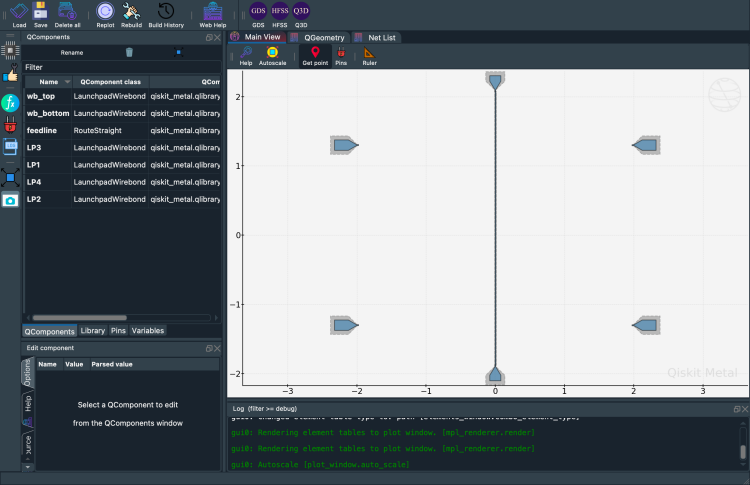

In [26]:
gui.rebuild()
gui.autoscale()
gui.screenshot("figures/ports.png")

Let's start with a rough sketch of what we want the design to look like.

<div style="text-align: center;">
  <div style="display: inline-flex; justify-content: center; align-items: center; gap: 20px;">
    <div style="flex: 1; text-align: center;">
      <img src="sketch.png" alt="Figure 1" style="width: 20%;">
    </div>
  </div>
</div>

**I am clearly an artist**

Nice! Let's now add the qubits and the resonators to the design.

Using the following orientations and positions for the qubits (and the Dolan JJs) for minimal cross-talk, best use of space, and ensuring that all the JJs can be written in single evaporation run

In [27]:
qubit_orientations = ['-90', '90', '-90', '90']
clt_orientations = ['-90', '90', '-90', '90']
positions = [('-1500um', '800um'), ('1500um', '1700um'),
             ('-1500um', '-750um'), ('1500um', '-200um')]
JJ_flips = [False, True, False, True]

In [28]:
# Lists to store the various design objects
cpw_objects = []
qubit_objects = []
clt_objects = []

# Loop through each entry to create design objects
for i in range(num_pairs):
    qubit_name = f'Q{i + 1}'
    clt_name = f'clt{i + 1}'
    cpw_name = f'cpw{i + 1}'

    # respecting the minimum JJ width
    jj_width = max(JJ_width, foundry_min_JJ_width)

    # Create the qubit
    qubit_objects.append(
        create_qubit(
            qubit_name,
            pos_x=positions[i][0],
            pos_y=positions[i][1],
            orientation=qubit_orientations[i],
            JJ_flip=JJ_flips[i],
            LJ=LJs[0],
            jj_width=jj_width,
            jj_length=JJ_length,
            claw_gap=data_qubit['claw_gap'][0],
            claw_length=data_qubit['claw_length'][0],
            claw_width=data_qubit['claw_width'][0],
            cross_length=data_qubit['cross_length'][0],
            cross_width=data_qubit['cross_width'][0],
            cross_gap=data_qubit['cross_gap'][0],
            ground_spacing=data_qubit['ground_spacing'][0]
        )
    )

    # Create the CLT
    clt_objects.append(
        create_clt(
            clt_name,
            orientation=clt_orientations[i],
            pos_y=positions[i][1],
            coupling_length=data_coupler['coupling_length'][0],
            coupling_space=data_coupler['coupling_space'][0],
            down_length=data_coupler['down_length'][0],
            prime_gap=data_coupler['prime_gap'][0],
            prime_width=data_coupler['prime_width'][0],
            second_gap=data_coupler['second_gap'][0],
            second_width=data_coupler['second_width'][0]
        )
    )

    # Create the CPW
    cpw_objects.append(
        create_cpw(
            cpw_name,
            start_component=clt_name,
            end_component=qubit_name,
            total_length=cpw_lengths[i],
            trace_gap=data_cpw['trace_gap'][0],
            trace_width=data_cpw['trace_width'][0]
        )
    )

09:08AM 06s WARNING [check_lengths]: For path table, component=cpw1, key=trace has short segments that could cause issues with fillet. Values in (1-1) (21-22)  are index(es) in shapely geometry.
09:08AM 06s WARNING [check_lengths]: For path table, component=cpw1, key=cut has short segments that could cause issues with fillet. Values in (1-1) (21-22)  are index(es) in shapely geometry.
09:08AM 06s WARNING [check_lengths]: For path table, component=cpw2, key=trace has short segments that could cause issues with fillet. Values in (19-20)  are index(es) in shapely geometry.
09:08AM 06s WARNING [check_lengths]: For path table, component=cpw2, key=cut has short segments that could cause issues with fillet. Values in (19-20)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path table, component=cpw3, key=trace has short segments that could cause issues with fillet. Values in (19-20)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path t

09:08AM 07s WARNING [check_lengths]: For path table, component=cpw1, key=trace has short segments that could cause issues with fillet. Values in (1-1) (21-22)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path table, component=cpw1, key=cut has short segments that could cause issues with fillet. Values in (1-1) (21-22)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path table, component=cpw2, key=trace has short segments that could cause issues with fillet. Values in (19-20)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path table, component=cpw2, key=cut has short segments that could cause issues with fillet. Values in (19-20)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path table, component=cpw3, key=trace has short segments that could cause issues with fillet. Values in (19-20)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path t

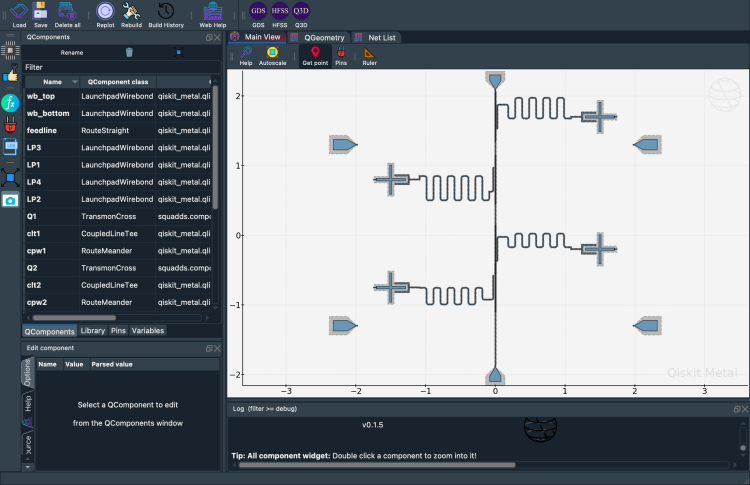

In [29]:
gui.rebuild()
gui.autoscale()
gui.screenshot("figures/chip1.png")

Lets zoom in on a qubit and its JJ to see how it looks.


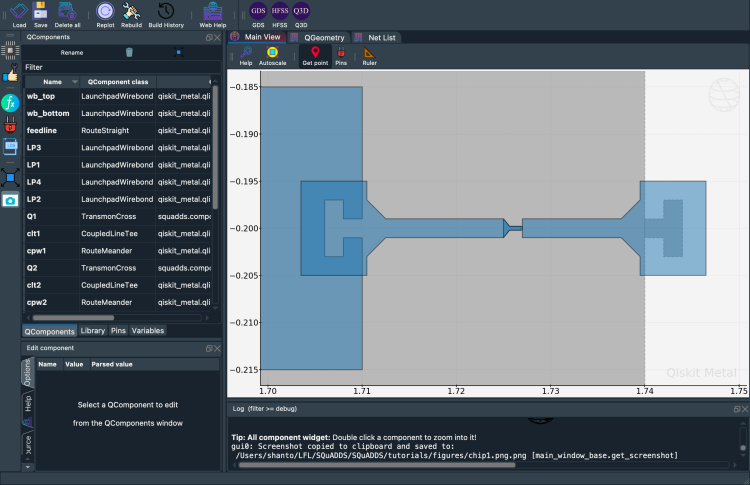

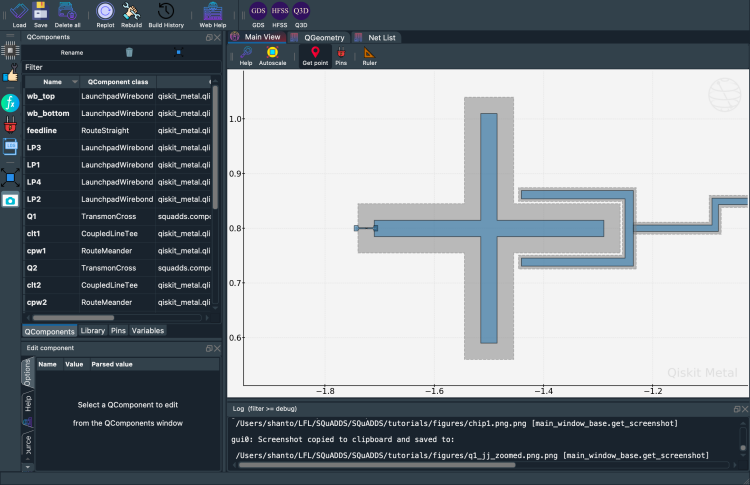

In [30]:
gui.zoom_on_components(['Q4_JJ_Dolan'])
gui.screenshot("figures/q1_jj_zoomed.png")

gui.zoom_on_components(['Q1'])
gui.screenshot("figures/q1_zoomed.png")

Awesome the junctions and the qubits look great. However, as we can see there are some "kinks" in some of the CPW lines - lets take a closer look

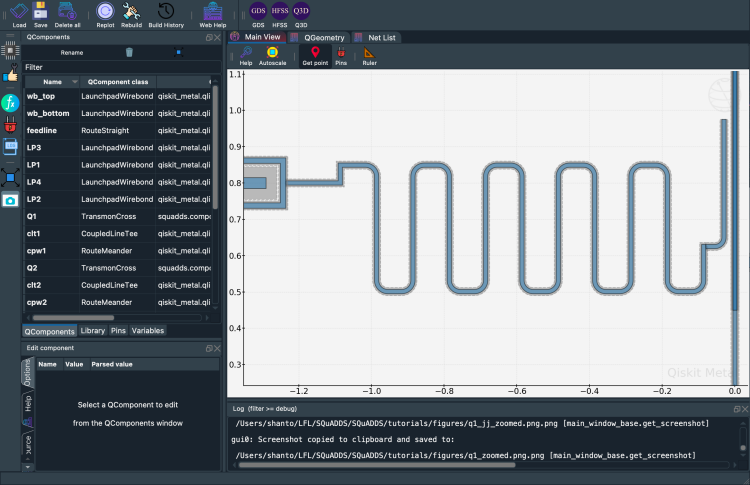

In [31]:
gui.zoom_on_components(['cpw1'])
gui.screenshot("figures/cpw1_zoomed.png")

We can fix this by changing the `lead.end_straight` and `lead.start_straigh` parameters. These numbers are to be adjusted until the issue is resolved.

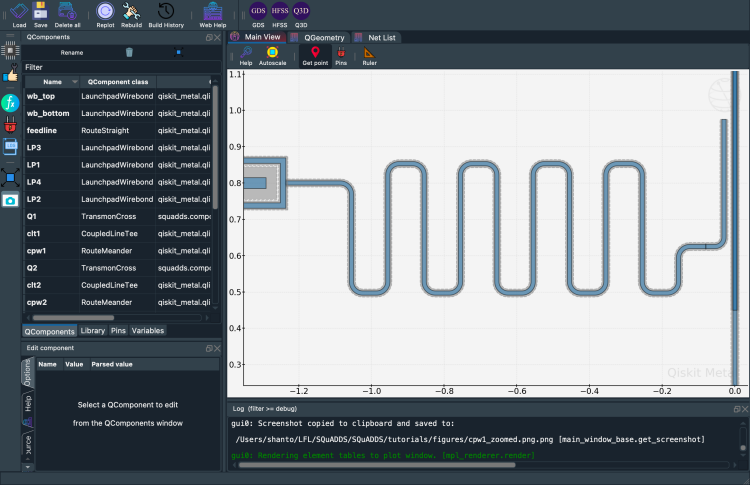

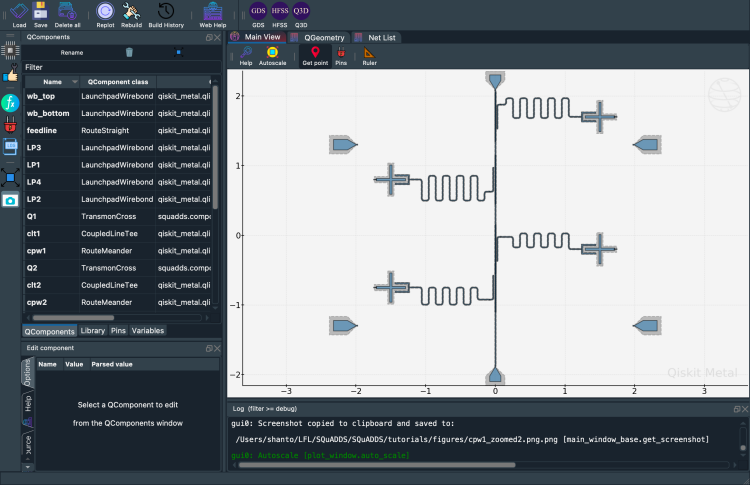

In [32]:
for cpw in cpw_objects:
    cpw.options.lead.start_straight = '75um'
    cpw.options.lead.end_straight = '50um'

gui.rebuild()
gui.zoom_on_components(['cpw1'])
gui.screenshot("figures/cpw1_zoomed2.png")

gui.autoscale()
gui.screenshot("figures/chip1_v1.png")

Great that fixed it!

Now, lets add the charge lines! To do this we need to first add the `OpenToGround` pins first. The following method will add the pins below/above the qubits as we specify with our chosen distance from it.

In [33]:
def create_charge_line_otgs(qubit, port, distance, orientation, index):
    # get the qubit position as float
    qubit_pos_x = float(qubit.options.pos_x[:-2])
    qubit_pos_y = float(qubit.options.pos_y[:-2])
    # get qubit cross length and cros gap
    qubit_cross_length = float(qubit.options.cross_length[:-2])
    qubit_cross_gap = float(qubit.options.cross_gap[:-2])
    qubit_name = qubit.name

    # get the port name
    port_name = port.name

    # set the otg name
    otg_name = f'otg_{index}'
    if orientation == "below":
        # place the OpenToGround termination below the qubit
        otg = OpenToGround(design, otg_name, Dict(pos_x=f"{qubit_pos_x}um", pos_y=f"{qubit_pos_y-qubit_cross_length-qubit_cross_gap-distance-6}um", orientation='90'))
    elif orientation == "above":
        # place the OpenToGround termination above the qubit
        otg = OpenToGround(design, otg_name, Dict(pos_x=f"{qubit_pos_x}um", pos_y=f"{qubit_pos_y+qubit_cross_length+qubit_cross_gap+distance-6}um", orientation='-90'))

    return otg



We will then need to add the charge lines from the ports to the `OpenToGround` pins. For this we are using `RouteAnchors` since all other options lead to 90 turns which are bad - cause radiation loss and massive TLS loss.

I only use one anchor which I set at the x position of the qubit center and the y position of the port center.

In [34]:
def create_charge_line(qubit, port, otg, name):
    # Create an OrderedDict for the anchors
    anch_list = OrderedDict()

    # Define anchors based on the qubit and port positions
    # You can adjust this based on your specific layout needs
    anch_list[0] = np.array([qubit.options.pos_x, port.options.pos_y])

    # Create the RouteAnchors instance
    route = RouteAnchors(design, name, Dict(
        fillet='80um',
        anchors=anch_list,
        pin_inputs=Dict(
            start_pin=Dict(component=port.name, pin='tie'),  # Start pin (port)
            end_pin=Dict(component=otg.name, pin='open')  # End pin (qubit)
        ),
        lead=Dict(
            start_straight='15um',  # Lead-in straight section
            end_straight='50um'     # Lead-out straight section
        )
    ))

    # Ensure the start and end pins are set, which defines head and tail points
    route.set_pin("start")  # Set the head (start pin)
    route.set_pin("end")    # Set the tail (end pin)

    # You can now get the points
    points = route.get_points()
    return route


Now, we instantiate these objects to make the charge lines. The "gaps" (i.e the distance between the charge line and the qubit) are to be chosen such that $T_1$ does not get too shortened.

09:08AM 09s WARNING [add_pins_to_table]: Component: 5 and pin: tie are already in net_info with net_id 33
09:08AM 09s WARNING [connect_pins]: NetId was not added for 5, tie, 33, start and will not be added to components.
09:08AM 09s WARNING [add_pins_to_table]: Component: 32 and pin: open are already in net_info with net_id 34
09:08AM 09s WARNING [connect_pins]: NetId was not added for 32, open, 33, end and will not be added to components.
09:08AM 10s WARNING [add_pins_to_table]: Component: 7 and pin: tie are already in net_info with net_id 35
09:08AM 10s WARNING [connect_pins]: NetId was not added for 7, tie, 35, start and will not be added to components.
09:08AM 10s WARNING [add_pins_to_table]: Component: 34 and pin: open are already in net_info with net_id 36
09:08AM 10s WARNING [connect_pins]: NetId was not added for 34, open, 35, end and will not be added to components.
09:08AM 10s WARNING [add_pins_to_table]: Component: 4 and pin: tie are already in net_info with net_id 37
09:08A

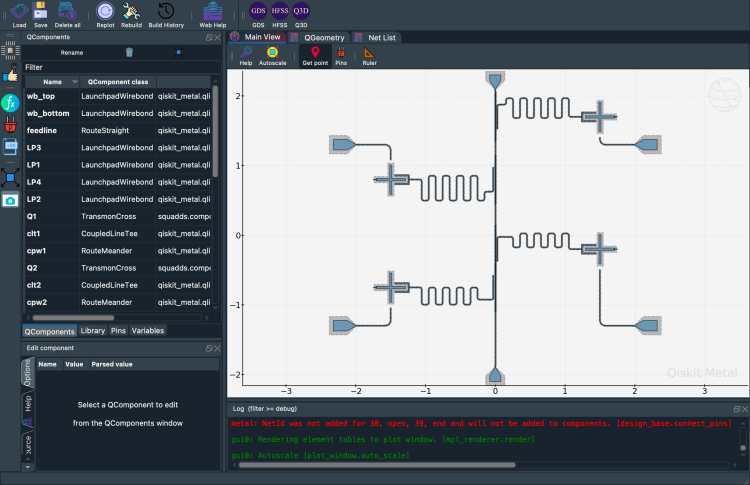

In [35]:
placement = ["above", "below", "below", "below"]
gaps = [50, 50, 50, 50] #um

otg_objects = []
charge_lines = []

for i in range(len(qubit_objects)):
    qubit = qubit_objects[i]
    port = charge_line_ports[i]
    otg = create_charge_line_otgs(qubit, port, gaps[i], placement[i],i+1)
    cl = create_charge_line(qubit, port, otg, f'cl_{i+1}')
    otg_objects.append(otg)
    charge_lines.append(cl)

gui.rebuild()
gui.autoscale()
gui.screenshot("figures/completed_chip.png")

## Exporting the Design

Set the layer numbers to your foundry/fab facility standards. 

For example, lets say our foundry wants all metal layers except for the charge lines to be layer 3 and the charge lines (and ports) to be layer 6.  *I have to admit this is a very odd request but I think its a good teaching point*


In [36]:
charge_line_layer = 6
metal_layer = 3

Assign metal layers to the respective QComponents.

In [37]:
comps = ['wb_top', 'wb_bottom', 'feedline']
numbered_comps = ['cpw', 'Q', 'clt', 'otg_']

metal_obj_names = comps + [f"{prefix}{i}" for prefix in numbered_comps for i in range(1, 5)]

for component_name, component in design.components.items():
    if component_name in metal_obj_names:
        component.options.layer = str(metal_layer)


Adjusting the charge line layers.

In [38]:
numbered_comps = ['cl_', 'LP']

charge_line_obj_names = [f"{prefix}{i}" for prefix in numbered_comps for i in range(1, 5)]

for component_name, component in design.components.items():
    if component_name in charge_line_obj_names:
        component.options.layer = str(charge_line_layer)

Rebuild the `gui` to save the changes.

In [39]:
gui.rebuild()

Processing the gds now.

We want to include ground plane holes to ensure that we don't trap flux.

In [40]:
a_gds = design.renderers.gds
a_gds.options['fabricate'] = 'True'
a_gds.options['cheese']['view_in_file']['main'][metal_layer] = True
a_gds.options['cheese']['view_in_file']['main'][charge_line_layer] = False
a_gds.options.no_cheese['view_in_file']['main']={3: True, 6: True}

Defining the ground plane holes.

In [41]:
a_gds.options.cheese.datatype = "2"
a_gds.options.cheese.cheese_0_x = "25um"
a_gds.options.cheese.cheese_0_y = "25um"
a_gds.options.cheese.edge_nocheese = "200um"
a_gds.options.cheese.delta_x = "125um"
a_gds.options.cheese.delta_y = "125um"

Defining the keepout regions.

In [42]:
a_gds.options.no_cheese.datatype = "3"
a_gds.options.no_cheese.buffer = "100um"

Exporting the gds file

In [44]:
filename = "gds_files/USC4Q_qff2024"
a_gds.export_to_gds(f"{filename}.gds")

09:08AM 43s WARNING [_qgeometry_to_gds]: Unexpected shapely object geometry.The variable qgeometry_element is <class 'numpy.float64'>, method can currently handle Polygon and FlexPath.
09:08AM 43s WARNING [_qgeometry_to_gds]: Unexpected shapely object geometry.The variable qgeometry_element is <class 'numpy.float64'>, method can currently handle Polygon and FlexPath.
09:08AM 43s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"/Users/shanto/LFL/SQuADDS/SQuADDS/resources".
09:08AM 43s WARNING [_check_either_cheese]: layer=20 is not in chip=main either in no_cheese_view_in_file or cheese_view_in_file from self.options.
09:08AM 43s WARNING [_check_either_cheese]: layer=60 is not in chip=main either in no_cheese_view_in_file or cheese_view_in_file from self.options.


1

`SQuADDS` also provides some useful gds post-procesessing methods available in the `squadds.gds.processing` module that we encourage you to explore (and contribute to!).

Now you can do run it through the DRC software and address any errors and thats it you are now ready to  go to your local cleanroom and make this device or send it to your foundry!

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Sadman Ahmed Shanto</p> 
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2024.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>